In [1]:
pwd

'/mmfs1/data/aglinska/BC-fMRI-AE/Notebooks'

In [2]:
import os
os.environ['CUDA_VISIBLE_DEVICES']='1'

In [3]:
whos

Variable   Type      Data/Info
------------------------------
os         module    <module 'os' from '/data/<...>da3/lib/python3.8/os.py'>


In [4]:
!free -g

              total        used        free      shared  buff/cache   available
Mem:            187          21         163           0           2         164
Swap:            11           0          11


In [5]:
!nvidia-smi

Wed Oct  6 15:09:01 2021       
+-----------------------------------------------------------------------------+
| NVIDIA-SMI 450.51.05    Driver Version: 450.51.05    CUDA Version: 11.0     |
|-------------------------------+----------------------+----------------------+
| GPU  Name        Persistence-M| Bus-Id        Disp.A | Volatile Uncorr. ECC |
| Fan  Temp  Perf  Pwr:Usage/Cap|         Memory-Usage | GPU-Util  Compute M. |
|                               |                      |               MIG M. |
|===============================+======================+======================|
|   0  Tesla V100-SXM2...  On   | 00000000:18:00.0 Off |                    0 |
| N/A   38C    P0    68W / 300W |  15660MiB / 16160MiB |     29%      Default |
|                               |                      |                  N/A |
+-------------------------------+----------------------+----------------------+
|   1  Tesla V100-SXM2...  On   | 00000000:3B:00.0 Off |                    0 |
| N/A   

|   3  Tesla V100-SXM2...  On   | 00000000:AF:00.0 Off |                    0 |
| N/A   37C    P0    57W / 300W |    456MiB / 16160MiB |      0%      Default |
|                               |                      |                  N/A |
+-------------------------------+----------------------+----------------------+
                                                                               
+-----------------------------------------------------------------------------+
| Processes:                                                                  |
|  GPU   GI   CI        PID   Type   Process name                  GPU Memory |
|        ID   ID                                                   Usage      |
|=============================================================================|
|    0   N/A  N/A     27201      C   ...ska/anaconda3/bin/python3    15657MiB |
|    1   N/A  N/A     27201      C   ...ska/anaconda3/bin/python3      453MiB |
|    2   N/A  N/A     27201      C   ...

In [6]:
import os
from datetime import datetime; now = datetime.now

analysis_name = 'CVAE_'+str(now())
save_dir = os.path.join('../Assets/tf_weights',analysis_name)
if not os.path.exists(save_dir):
    os.mkdir(save_dir)
    
print(analysis_name)

CVAE_2021-10-06 15:09:01.820789


In [7]:
# CHECK GPU
import nvidia_smi
try:
    nvidia_smi.nvmlInit()

    handle = nvidia_smi.nvmlDeviceGetHandleByIndex(0)
    # card id 0 hardcoded here, there is also a call to get all available card ids, so we could iterate

    info = nvidia_smi.nvmlDeviceGetMemoryInfo(handle)

    print("Total memory:", (info.total/1024/1024/1024))
    print("Free memory:", (info.free/1024/1024/1024))
    print("Used memory:", (info.used/1024/1024/1024))

    nvidia_smi.nvmlShutdown()
except:
    pass

Total memory: 15.78173828125
Free memory: 0.48828125
Used memory: 15.29345703125


In [8]:
## SET UP

In [9]:
import numpy as np
import pandas as pd
from tqdm import tqdm
from matplotlib import pyplot as plt

from functools import partial
from tqdm import tqdm
from umap import UMAP
tqdm = partial(tqdm, position=0, leave=True) 

In [10]:
df = pd.read_csv('../Data/ABIDE_df2.csv')
df = df.iloc[~pd.isna(df['bids_folder']).values]
data_dir = '../Assets/fc_mats_32smooth_new/'

In [11]:
files = [file for file in os.listdir(data_dir) if file.endswith('.npy')]
files.sort()
files[0:5]

['sub-CMUa0050642.npy',
 'sub-CMUa0050646.npy',
 'sub-CMUa0050647.npy',
 'sub-CMUa0050649.npy',
 'sub-CMUa0050653.npy']

In [12]:
subs_with_matFiles = [file.split('.')[0] for file in files]
df = df.iloc[np.array([sub in subs_with_matFiles for sub in df['bids_folder'].values])]
n_subs = len(df)
print(n_subs)

# Check if subject has .nii file
has_file = np.array([os.path.exists(os.path.join(data_dir,sub + '.npy')) for sub in df['bids_folder'].values])
print(has_file.mean())
assert has_file.mean()==1.0, 'fuck'

assert len(subs_with_matFiles)==len(df),'no'
df = df.sort_values(by='bids_folder')
assert all([subs_with_matFiles[i]==df['bids_folder'].values[i] for i in range(n_subs)]), 'out of order'

df.index = np.arange(n_subs)

1048


1.0


In [13]:
%%time
from importlib import reload
import helper_funcs;reload(helper_funcs);from helper_funcs import *
del helper_funcs
import make_models;reload(make_models);from make_models import *
del make_models

from IPython import display
import sys
from sklearn.decomposition import PCA
import seaborn as sns

import tensorflow as tf
reload(tf)

CPU times: user 55.3 ms, sys: 5.08 ms, total: 60.4 ms
Wall time: 182 ms


<module 'tensorflow' from '/data/aglinska/anaconda3/lib/python3.8/site-packages/tensorflow/__init__.py'>

In [14]:
import tensorflow as tf
tf.test.gpu_device_name()

'/device:GPU:0'

In [15]:
data_dir = '../Assets/fc_mats_32smooth_new'
data_loader = cvae_data_loader(data_dir=data_dir, df=df, batch_size=32)
batch_asd,batch_td,batch_df = data_loader.get_batch()

In [16]:
data_size = np.hstack((n_subs,batch_asd.shape[1:]))

In [17]:
import make_models;reload(make_models);from make_models import *
batch_size = 16

cvae, z_encoder, s_encoder, cvae_decoder = get_fMRI_CVAE_4D(input_shape=tuple(data_size[1::]),
                                                             latent_dim=16,
                                                             beta=1,
                                                             gamma=1,
                                                             disentangle=True,
                                                             bias=True,
                                                             batch_size = batch_size,
                                                             kernel_size = 3,
                                                             filters = 8,
                                                             intermediate_dim = 128,
                                                             nlayers = 5,
                                                             learning_rate=0.001,
                                                             opt=None)

In [18]:
tuple(data_size)

(1048, 32, 32, 32, 51)

In [19]:
loss = list()
c_sim = list()
all_rsas = list()

In [20]:
data_loader = cvae_data_loader(data_dir=data_dir, df=df, batch_size=batch_size)

<Figure size 432x288 with 0 Axes>

/mmfs1/data/aglinska/BC-fMRI-AE/Notebooks/helper_funcs.py:190: MatplotlibDeprecationWarning: Passing non-integers as three-element position specification is deprecated since 3.3 and will be removed two minor releases later.
  plt.subplot(nrows,ncols/2,1) # PLOT LOSS


<Figure size 432x288 with 0 Axes>

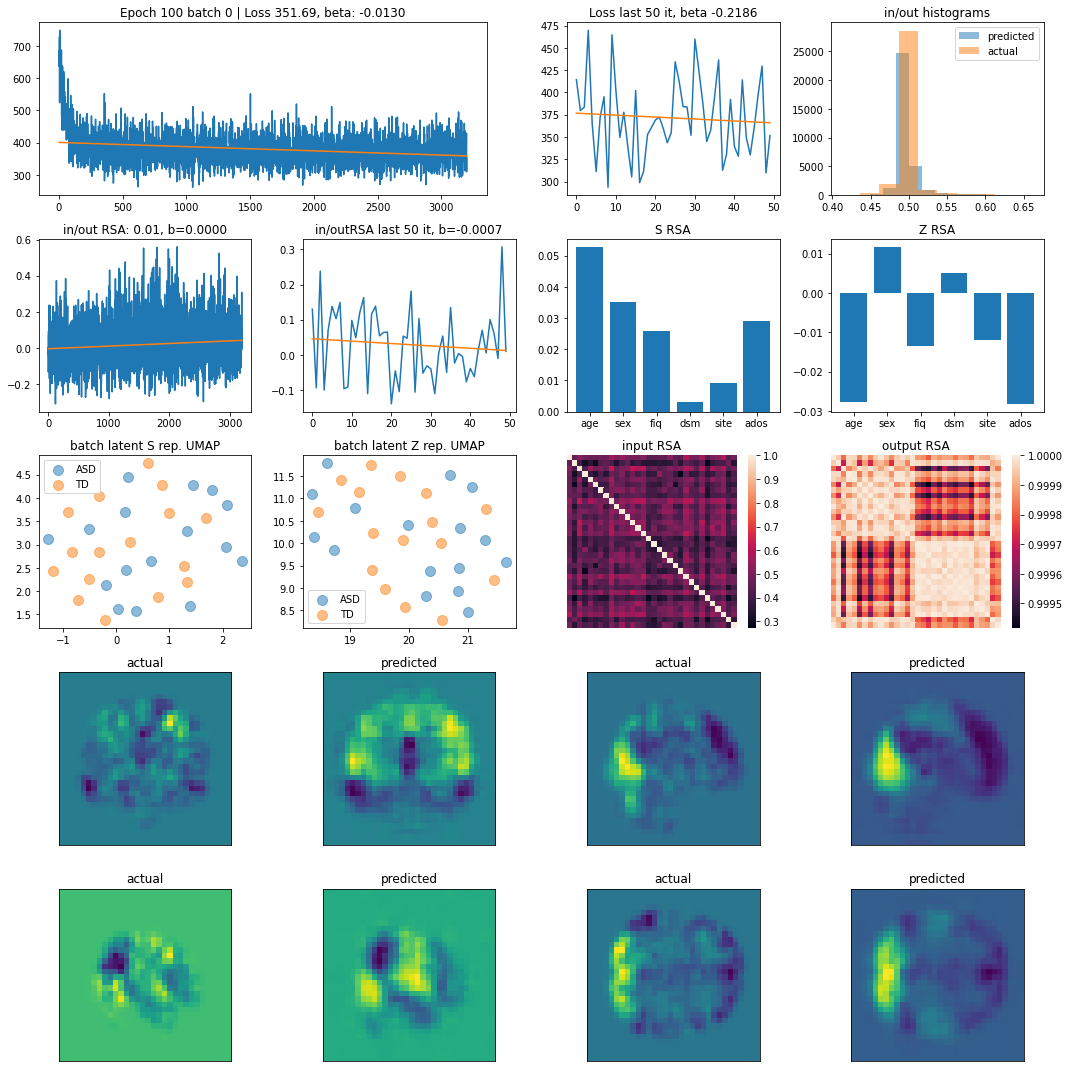

100%|██████████| 32/32 [28:05<00:00, 52.75s/it]

100%|██████████| 100/100 [14:04:02<00:00, 1104.34s/it]

100%|██████████| 100/100 [14:04:02<00:00, 506.43s/it] 

In [21]:
import make_models;reload(make_models);from make_models import *
import helper_funcs;reload(helper_funcs);from helper_funcs import *

for epoch in tqdm(range(100),position=0, leave=True):
    for i in tqdm(range(data_loader.n_batches),position=1, leave=False):
        
        patient_batch,control_batch,batch_df = data_loader.get_batch() # Get a batch
        hist = cvae.train_on_batch([patient_batch,control_batch]) # pass a batch
        assert not np.isnan(hist),'loss is NaN - you f**cked up'  # check nothing crashed
        loss.append(hist) # keep track of loss
        
        cvae.save_weights(os.path.join(save_dir,'cvae_weights')) # SAVE WEIGHTS
        np.save(os.path.join(save_dir,'cvae_loss.npy'),np.array(loss)) # Save loss
        
        if np.mod(i,10)==0:
            batch_rsas = get_batch_rsas(data_dir,df,z_encoder,s_encoder,batch_size=(df['DX_GROUP'].values==1).sum())
        
        c_sim,all_rsas = cvae_dashboard(data_loader.epoch,
                                        data_loader.b,
                                        i,
                                        cvae,z_encoder,
                                        s_encoder,
                                        loss,
                                        all_rsas,
                                        c_sim,
                                        df,
                                        patient_batch,
                                        control_batch,
                                        batch_rsas,
                                        red='UMAP') # plot training progress
        

In [22]:
z_encoder.summary(line_length=100)

Model: "z_encoder"
____________________________________________________________________________________________________
Layer (type)                     Output Shape          Param #     Connected to                     
tg_inputs (InputLayer)           [(None, 32, 32, 32, 5 0                                            
____________________________________________________________________________________________________
conv3d (Conv3D)                  (None, 16, 16, 16, 16 22048       tg_inputs[0][0]                  
____________________________________________________________________________________________________
conv3d_1 (Conv3D)                (None, 8, 8, 8, 32)   13856       conv3d[0][0]                     
____________________________________________________________________________________________________
conv3d_2 (Conv3D)                (None, 4, 4, 4, 64)   55360       conv3d_1[0][0]                   
________________________________________________________________________

In [23]:
s_encoder.summary(line_length=100)

Model: "s_encoder"
____________________________________________________________________________________________________
Layer (type)                     Output Shape          Param #     Connected to                     
tg_inputs (InputLayer)           [(None, 32, 32, 32, 5 0                                            
____________________________________________________________________________________________________
conv3d_5 (Conv3D)                (None, 16, 16, 16, 16 22048       tg_inputs[0][0]                  
____________________________________________________________________________________________________
conv3d_6 (Conv3D)                (None, 8, 8, 8, 32)   13856       conv3d_5[0][0]                   
____________________________________________________________________________________________________
conv3d_7 (Conv3D)                (None, 4, 4, 4, 64)   55360       conv3d_6[0][0]                   
________________________________________________________________________

In [24]:
cvae.summary(line_length=100)

Model: "contrastive_vae"
____________________________________________________________________________________________________
Layer (type)                     Output Shape          Param #     Connected to                     
tg_inputs (InputLayer)           [(None, 32, 32, 32, 5 0                                            
____________________________________________________________________________________________________
conv3d (Conv3D)                  (None, 16, 16, 16, 16 22048       tg_inputs[0][0]                  
____________________________________________________________________________________________________
bg_inputs (InputLayer)           [(None, 32, 32, 32, 5 0                                            
____________________________________________________________________________________________________
conv3d_1 (Conv3D)                (None, 8, 8, 8, 32)   13856       conv3d[0][0]                     
__________________________________________________________________


                                                                   lambda_1[0][0]                   
____________________________________________________________________________________________________
tf_op_layer_Reshape_1 (TensorFlo [(None,)]             0           decoder[0][0]                    
____________________________________________________________________________________________________
tf_op_layer_Reshape (TensorFlowO [(None,)]             0           tg_inputs[0][0]                  
____________________________________________________________________________________________________
tf_op_layer_Reshape_3 (TensorFlo [(None,)]             0           decoder[1][0]                    
____________________________________________________________________________________________________
tf_op_layer_Reshape_2 (TensorFlo [(None,)]             0           bg_inputs[0][0]                  
__________________________________________________________________________________________

In [25]:
cvae_decoder.summary(line_length=100)

Model: "decoder"
____________________________________________________________________________________________________
Layer (type)                                 Output Shape                            Param #        
z_sampling (InputLayer)                      [(None, 32)]                            0              
____________________________________________________________________________________________________
dense_2 (Dense)                              (None, 128)                             4224           
____________________________________________________________________________________________________
dense_3 (Dense)                              (None, 256)                             33024          
____________________________________________________________________________________________________
reshape (Reshape)                            (None, 1, 1, 1, 256)                    0              
__________________________________________________________________________